# STEP 4 - Making DRL PySC2 Agent

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys; sys.path.append('..')

## 0. Runnning 'Agent code' on jupyter notebook 

In [4]:
### unfortunately, PySC2 uses Abseil, which treats python code as if its run like an app
# This does not play well with jupyter notebook
# So we will need to monkeypatch sys.argv


import sys
#sys.argv = ["python", "--map", "AbyssalReef"]
sys.argv = ["python", "--map", "Simple64"]

# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Run an agent."""

#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

import importlib
import threading

from absl import app
from absl import flags
from future.builtins import range  # pylint: disable=redefined-builtin

from pysc2 import maps
from pysc2.env import available_actions_printer
from pysc2.env import run_loop
from pysc2.env import sc2_env
from pysc2.lib import point_flag
from pysc2.lib import stopwatch
from pysc2.lib import actions
from pysc2.lib import features

FLAGS = flags.FLAGS

# because of Abseil's horrible design for running code underneath Colabs
# We have to pull out this ugly hack from the hat
if "flags_defined" not in globals():
    flags.DEFINE_bool("render", True, "Whether to render with pygame.")
    point_flag.DEFINE_point("feature_screen_size", "32",
                            "Resolution for screen feature layers.")
    point_flag.DEFINE_point("feature_minimap_size", "32",
                            "Resolution for minimap feature layers.")
    point_flag.DEFINE_point("rgb_screen_size", None,
                            "Resolution for rendered screen.")
    point_flag.DEFINE_point("rgb_minimap_size", None,
                            "Resolution for rendered minimap.")
    flags.DEFINE_enum("action_space", "RAW", sc2_env.ActionSpace._member_names_,  # pylint: disable=protected-access
                      "Which action space to use. Needed if you take both feature "
                      "and rgb observations.")
    flags.DEFINE_bool("use_feature_units", False,
                      "Whether to include feature units.")
    flags.DEFINE_bool("use_raw_units", True,
                      "Whether to include raw units.")
    flags.DEFINE_integer("raw_resolution", 64, "Raw Resolution.")
    flags.DEFINE_bool("disable_fog", True, "Whether to disable Fog of War.")

    flags.DEFINE_integer("max_agent_steps", 0, "Total agent steps.")
    flags.DEFINE_integer("game_steps_per_episode", None, "Game steps per episode.")
    flags.DEFINE_integer("max_episodes", 0, "Total episodes.")
    flags.DEFINE_integer("step_mul", 48, "Game steps per agent step.")
    flags.DEFINE_float("fps", 22.4, "Frames per second to run the game.")

    #flags.DEFINE_string("agent", "sc2.agent.BasicAgent.ZergBasicAgent",
    #                    "Which agent to run, as a python path to an Agent class.")
    #flags.DEFINE_enum("agent_race", "zerg", sc2_env.Race._member_names_,  # pylint: disable=protected-access
    #                  "Agent 1's race.")
    flags.DEFINE_string("agent", "TerranRLAgentWithRawActsAndRawObs",
                        "Which agent to run, as a python path to an Agent class.")
    flags.DEFINE_enum("agent_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 1's race.")

    flags.DEFINE_string("agent2", "Bot", "Second agent, either Bot or agent class.")
    flags.DEFINE_enum("agent2_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 2's race.")
    flags.DEFINE_enum("difficulty", "very_easy", sc2_env.Difficulty._member_names_,  # pylint: disable=protected-access
                      "If agent2 is a built-in Bot, it's strength.")

    flags.DEFINE_bool("profile", False, "Whether to turn on code profiling.")
    flags.DEFINE_bool("trace", False, "Whether to trace the code execution.")
    flags.DEFINE_integer("parallel", 1, "How many instances to run in parallel.")

    flags.DEFINE_bool("save_replay", True, "Whether to save a replay at the end.")

    flags.DEFINE_string("map", None, "Name of a map to use.")
    flags.mark_flag_as_required("map")

flags_defined = True

def run_thread(agent_classes, players, map_name, visualize):
  """Run one thread worth of the environment with agents."""
  with sc2_env.SC2Env(
      map_name=map_name,
      players=players,
      agent_interface_format=sc2_env.parse_agent_interface_format(
        #feature_screen=FLAGS.feature_screen_size,
        #feature_minimap=FLAGS.feature_minimap_size,
        feature_screen=32,
        feature_minimap=32,
        #feature_dimensions=features.Dimensions(screen=32, minimap=32),
        rgb_screen=FLAGS.rgb_screen_size,
        rgb_minimap=FLAGS.rgb_minimap_size,
        action_space=FLAGS.action_space,
        use_raw_units=FLAGS.use_raw_units,
        raw_resolution=FLAGS.raw_resolution),
      step_mul=FLAGS.step_mul,
      game_steps_per_episode=FLAGS.game_steps_per_episode,
      disable_fog=FLAGS.disable_fog,
      visualize=visualize) as env:
    #env = available_actions_printer.AvailableActionsPrinter(env)
    agents = [agent_cls() for agent_cls in agent_classes]
    run_loop.run_loop(agents, env, FLAGS.max_agent_steps, FLAGS.max_episodes)
    if FLAGS.save_replay:
      env.save_replay(agent_classes[0].__name__)

def main(unused_argv):
  """Run an agent."""
  #stopwatch.sw.enabled = FLAGS.profile or FLAGS.trace
  #stopwatch.sw.trace = FLAGS.trace

  map_inst = maps.get(FLAGS.map)

  agent_classes = []
  players = []

  #agent_module, agent_name = FLAGS.agent.rsplit(".", 1)
  #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
  #agent_classes.append(agent_cls)
  agent_classes.append(TerranRLAgentWithRawActsAndRawObs)
  players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent_race]))

  if map_inst.players >= 2:
    if FLAGS.agent2 == "Bot":
      players.append(sc2_env.Bot(sc2_env.Race[FLAGS.agent2_race],
                                 sc2_env.Difficulty[FLAGS.difficulty]))
    else:
      #agent_module, agent_name = FLAGS.agent2.rsplit(".", 1)
      #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
      agent_classes.append(TerranRandomAgent)
      players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent2_race]))

  threads = []
  for _ in range(FLAGS.parallel - 1):
    t = threading.Thread(target=run_thread,
                         args=(agent_classes, players, FLAGS.map, False))
    threads.append(t)
    t.start()

  run_thread(agent_classes, players, FLAGS.map, FLAGS.render)

  for t in threads:
    t.join()

  if FLAGS.profile:
    pass
    #print(stopwatch.sw)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Creating a PySC2 Agent with Raw Actions & Observations

![StarCraft2 PySC2 interfaces](./images/StarCraft2_PySC2_interfaces.png)

ref : https://on-demand.gputechconf.com/gtc/2018/presentation/s8739-machine-learning-with-starcraft-II.pdf

### < PySC2 Interfaces 3가지 종류 >

### 1st, Rendered
* Decomposed :
    - Screen, minimap, resources, available actions
* Same control as humans :
    - Pixel coordinates
    - Move camera
    - Select unit/rectangle
* Great for Deep Learning, but hard

### 2nd, Feature Layer
* Same actions : still in pixel space
* Same decomposed observations, but more abstract
    - Orthogonal camera 
* Layers:
    - unit type
    - unit owner
    - selection
    - health
    - unit density
    - etc
    
### 3rd, Raw
* List of units and state
* Control each unit individually in world coordinates
* Gives all observable state (no camera)
* Great for scripted agents and programmatic replay analysis

### < Raw Actions & Observations 을 사용하는 이유>
* Raw Actions & Observations 은 world cordinates를 사용하므로 전체 Map을 한번에 관찰하고 Camera를 이동하지 않고도 Map 상의 어느 곳에서도 Action을 취할 수 있는 새로운 형태의 Feature 이다.
* 이번 과정에 SL(Supervised Learning, 지도학습)을 활용한 학습은 없지만 스타크래프트 2 리플레이를 활용한 SL은 Raw Actions & Observations를 활용한 "programmatic replay analysis"가 필요하다.
* 인간 플레이어를 이긴 DeepMind의 AlphaStar의 주요 변경사항 중의 하나는 Raw Actions & Observations 의 활용이다.

In [ ]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9):
        self.actions = actions
        self.learning_rate = learning_rate
        self.reward_decay = reward_decay
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation, e_greedy=0.9):
        self.check_state_exist(observation)
        if np.random.uniform() < e_greedy:
            state_action = self.q_table.loc[observation, :]
            action = np.random.choice(
              state_action[state_action == np.max(state_action)].index)
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.reward_decay * self.q_table.loc[s_, :].max()
        else:
            q_target = r
            
        self.q_table.loc[s, a] += self.learning_rate * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(pd.Series([0] * len(self.actions), 
                                                       index=self.q_table.columns, 
                                                       name=state))

In [ ]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [ ]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

In [ ]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()
        self.qlearn = QLearningTable(self.actions)
        self.new_game()
        self.data_file = 'rlagent_with_raw_acts_and_obs_learning_data'
        if os.path.isfile(self.data_file + '.gz'):
            self.qlearn.q_table = pd.read_pickle(self.data_file + '.gz', compression='gzip')

    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))

    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)
        
        #time.sleep(0.5)
        
        state = str(self.get_state(obs))
        action = self.qlearn.choose_action(state)
        if self.previous_action is not None:
            self.qlearn.learn(self.previous_state,
                              self.previous_action,
                              obs.reward,
                              'terminal' if obs.last() else state)
        self.previous_state = state
        self.previous_action = action
        
        if obs.last():
            self.qlearn.q_table.to_pickle(self.data_file + '.gz', 'gzip')

        return getattr(self, action)(obs)

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 2. Applying NaiveDQN to a PySC2 Agent

- Implementing "Neural Q-Learning"

In [ ]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle

from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

import torch
from torch.utils.tensorboard import SummaryWriter

from skdrl.pytorch.model.mlp import NaiveMultiLayerPerceptron

In [ ]:
DATA_FILE = 'rlagent_with_naive_dqn'
SCORE_FILE = 'rlagent_with_naive_dqn_score'

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

class NaiveDQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        super(NaiveDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        self.criteria = nn.MSELoss()

    def choose_action(self, state):
        qs = self.qnet(state)  # Notice that qs is 2d tensor [batch x action]

        if self.train:  # epsilon-greedy policy
            #prob = np.random.uniform(0.0, 1.0, 1)
            #if torch.from_numpy(prob).float() <= self.epsilon:  # random
            if random.random() <= self.epsilon: # random
                action = np.random.choice(range(self.action_dim))
            else:  # greedy
                action = qs.argmax(dim=-1)
        else:  # greedy policy
            action = qs.argmax(dim=-1)
        return int(action)

    def learn(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
        # Q-Learning target
        q_max, _ = self.qnet(ns).max(dim=-1)
        q_target = r + self.gamma * q_max * (1 - done)

        # Don't forget to detach `td_target` from the computational graph
        q_target = q_target.detach()

        # Or you can follow a better practice as follows:
        """
        with torch.no_grad():
            q_max, _ = self.qnet(ns).max(dim=-1)
            q_target = r + self.gamma * q_max * (1 - done)
        """

        loss = self.criteria(self.qnet(s)[0, a], q_target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        return loss

In [ ]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [ ]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

s_dim = 21
a_dim = 6

### DRL 모델의 성능 추이를 보기위해 Reward의 평균 추이를 이용한다. 이때 단순이동평균 보다는 지수이동평균이 적절하다.

### 지수이동평균(EMA:Exponential Moving Average) 란?
지수이동평균(Exponential Moving Average)은 과거의 모든 기간을 계산대상으로 하며 최근의 데이타에 더 높은 가중치를 두는 일종의 가중이동평균법이다.

단순이동평균의 계산법에 비하여 원리가 복잡해 보이지만 실제로 이동평균을 산출하는 방법은 Previous Step의 지수이동평균값과 평활계수(smoothing constant) 그리고 당일의 가격만으로 구할 수 있으므로 Previous Step의 지수이동평균값만 구해진다면 오히려 간단한 편이다.

따라서 지수이동평균은 단순이동평균에 비해 몇가지 중요한 강점을 가진다.

첫째는 가장 최근의 Step에 가장 큰 가중치를 둠으로 해서 최근의 Episode들을 잘 반영한다는 점이고, 둘째는 단순이동평균에서와 같이 오래된 데이타를 갑자기 제외하지 않고 천천히 그 영향력을 사라지게 한다는 점이다.
또한 전 기간의 데이타를 분석대상으로 함으로써 가중이동평균에서 문제되는 특정 기간의 데이타만을 분석대상으로 한다는 단점도 보완하고 있다.

### 지수이동평균(EMA:Exponential Moving Average) 계산

지수이동평균은 가장 최근의 값에 많은 가중치를 부여하고 오래 된 값에는 적은 가중치를 부여한다. 비록 오래 된 값이라고 할지라도 완전히 무시하지는 않고 적게나마 반영시켜 계산한다는 장점이 있다. 단기 변동성을 포착하려는 것이 목적이다.

EMA=Previous Step 지수이동평균+(k∗(Current Step Reward − Previous Step 지수이동평균))


In [ ]:
class EMAMeter:

    def __init__(self,
                 alpha: float = 0.5):
        self.s = None
        self.alpha = alpha

    def update(self, y):
        if self.s is None:
            self.s = y
        else:
            self.s = self.alpha * y + (1 - self.alpha) * self.s

In [ ]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()

        self.s_dim = 21
        self.a_dim = 6
        self.lr = 1e-4
        self.gamma = 1.0
        self.epsilon = 1.0

        self.qnetwork = NaiveMultiLayerPerceptron(input_dim=self.s_dim,
                           output_dim=self.a_dim,
                           num_neurons=[128],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)

        self.data_file = DATA_FILE
        if os.path.isfile(self.data_file + '.pt'):
            self.qnetwork.load_state_dict(torch.load(self.data_file + '.pt'))

        self.dqn = NaiveDQN(state_dim=self.s_dim,
                             action_dim=self.a_dim,
                             qnet=self.qnetwork,
                             lr=self.lr,
                             gamma=self.gamma,
                             epsilon=self.epsilon).to(device)

        self.score_file = SCORE_FILE
        
        self.print_every = 50
        self.ema_factor = 0.5
        self.ema = EMAMeter(self.ema_factor)
        self.cum_reward = 0
        self.cum_loss = 0
        self.episode_count = 0

        self.new_game()

    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None
        self.cum_reward = 0
        self.cum_loss = 0

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))

    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)

        #time.sleep(0.5)

        state = self.get_state(obs)
        state = torch.tensor(state).float().view(1, self.s_dim).to(device)
        action_idx = self.dqn.choose_action(state)
        action = self.actions[action_idx]
        done = True if obs.last() else False
        if self.previous_action is not None:
            loss = self.dqn.learn(self.previous_state.to(device),
                              torch.tensor(self.previous_action).view(1, 1).to(device),
                              torch.tensor(obs.reward).view(1, 1).to(device),
                              state.to(device),
                              torch.tensor(done).float().view(1, 1).to(device)
                              )
            self.cum_loss += loss.detach().numpy()
        self.cum_reward += obs.reward
        self.previous_state = state
        self.previous_action = action_idx

        if obs.last():
            self.episode_count = self.episode_count + 1
            torch.save(self.dqn.qnet.state_dict(), self.data_file + '.pt')

            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(self.score_file + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
            
            self.ema.update(self.cum_reward)
            writer.add_scalar("Loss/online", self.cum_loss/obs.observation.game_loop, self.episode_count)
            writer.add_scalar("Score", self.ema.s, self.episode_count)

            if self.episode_count % self.print_every == 0:
                print("Episode {} || EMA: {} || EPS : {}".format(self.episode_count, self.ema.s, self.dqn.epsilon))

            if self.episode_count >= 150:
                self.dqn.epsilon *= 0.999

        return getattr(self, action)(obs)

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

### [Winning rate graph]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [ ]:
np_scores = np.array(scores)
np_scores

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc='best')
plt.show()

## 3. Applying Vanilla DQN to a PySC2 Agent

구현된 기능

- Implementing 'Experience Replay' : 
    - 'Maximization Bias' 문제를 발생시키는 원인 중 하나인 'Sample간의 시간적 연관성'을 해결하기 위한 방법
    - Online Learning 에서 Batch Learning 으로 학습방법 바뀜 : Online update 는 Batch update 보다 일반적으로 Validation loss 가 더 높게 나타남.
    - Reinforcement Learning for Robots. Using Neural Networks. Long -Ji Lin. January 6, 1993. 논문에서 최초로 연구됨 http://isl.anthropomatik.kit.edu/pdf/Lin1993.pdf

- Implementing 'Fixed Q-Target' : 
    - 'Moving Q-Target' 문제 해결하기 위한 방법
    - 2015년 Nature 버전 DQN 논문에서 처음 제안됨. https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning 


구현되지 않은 기능

- Implementing 'Sensory Input Feature-Extraction' :
    - 게임의 Raw Image 를 Neural Net에 넣기 위한 Preprocessing(전처리) 과정
    - Raw Image 의 Sequence중 '최근 4개의 이미지'(과거 정보)를 하나의 새로운 State로 정의하여 non-MDP를 MDP 문제로 바꾸는 Preprocessing 과정 
    - CNN(합성곱 신경망)을 활용한 '차원의 저주' 극복

In [5]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle

from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

import torch
from torch.utils.tensorboard import SummaryWriter

from skdrl.pytorch.model.mlp import NaiveMultiLayerPerceptron
from skdrl.pytorch.model.cnn import CNNFC
from skdrl.common.memory.memory import ExperienceReplayMemory

In [6]:
DATA_FILE_QNET = 'rlagent_with_vanilla_dqn_qnet'
DATA_FILE_QNET_TARGET = 'rlagent_with_vanilla_dqn_qnet_target'
SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

### Q-update 공식

#### 1. Online Q-learning
![Online Q-learning](./images/q-update-experience-replay.png)

#### 2. Online Q-learning with Function Approximation
![Online Q-learning with Function Approximation](./images/q-update-function-approximation.png)

#### 3. Batch Q-learning with Function Approximation & Experience Replay
![Batch Q-learning with Function Approximation & Experience Replay](./images/q-update-online.png)

### Moving target problem

#### 1. Function Approximation을 사용하지 않는 Q-learning 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 주지 않는다.
![Moving target Q-learning](./images/moving-target_q-learing_case.png)

#### 2. Function Approximation을 사용하는 Q-learnig 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 준다.
![Moving target Q-learning with Function Approximation](./images/moving-target_q-learing_with_function_approximation_case.png)

### Moving target 문제는 Deep Neural Network를 사용하는 Function Approximation 기법인 경우 심해지는 경향성이 있음.

image ref : Fast Campus RL online courese

### `nn.SmoothL1Loss()` = Huber loss 란?

Mean-squared Error (MSE) Loss 는 데이터의 outlier에 매우 취약하다.
어떤 이유로 타겟하는 레이블 y (이 경우는 q-learning target)이 noisy 할때를 가정하면, 잘못된 y 값을 맞추기 위해 파라미터들이 너무 sensitive 하게 움직이게 된다.

이런 현상은 q-learning 의 학습초기에 매우 빈번해 나타난다. 이러한 문제를 조금이라도 완화하기 위해서 outlier에 덜 민감한 Huber loss 함수를 사용한다.

### SmoothL1Loss (aka Huber loss)

$$loss(x,y) = \frac{1}{n}\sum_i z_i$$
$|x_i - y_i| <1$ 일때,
$$z_i = 0.5(x_i - y_i)^2$$
$|x_i - y_i| \geq1$ 일때,
$$z_i = |x_i - y_i|-0.5$$

ref : https://pytorch.org/docs/master/generated/torch.nn.SmoothL1Loss.html

In [100]:
import torch
import torch.nn as nn
import numpy as np
import random

class DQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 qnet_target: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        """
        :param state_dim: input state dimension
        :param action_dim: action dimension
        :param qnet: main q network
        :param qnet_target: target q network
        :param lr: learning rate
        :param gamma: discount factor of MDP
        :param epsilon: E-greedy factor
        """

        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        # target network related
        qnet_target.load_state_dict(qnet.state_dict())
        self.qnet_target = qnet_target
        self.criteria = nn.SmoothL1Loss()

    def choose_action(self, state):
        qs = self.qnet(state)
        #prob = np.random.uniform(0.0, 1.0, 1)
        #if torch.from_numpy(prob).float() <= self.epsilon:  # random
        if random.random() <= self.epsilon: # random
            action = np.random.choice(range(self.action_dim))
        else:  # greedy
            print(qs)
            action = qs.argmax(dim=-1)
            #action = torch.argmax(qs, dim=-1)
        return int(action)

    def learn(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state

        # compute Q-Learning target with 'target network'
        with torch.no_grad():
            q_max, _ = self.qnet_target(ns).max(dim=-1, keepdims=True)
            q_target = r + self.gamma * q_max * (1 - done)

        q_val = self.qnet(s).gather(1, a)
        #print(q_val)
        #print(q_target)
        loss = self.criteria(q_val, q_target)
        print('loss : {}'.format(loss))

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()


def prepare_training_inputs(sampled_exps, device='cpu'):
    map_screen = []
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    for sampled_exp in sampled_exps:
        states.append(sampled_exp[0])
        actions.append(sampled_exp[1])
        rewards.append(sampled_exp[2])
        next_states.append(sampled_exp[3])
        dones.append(sampled_exp[4])
        #map_screen.append(sampled_exp[5])

    states = torch.cat(states, dim=0).float().to(device)
    actions = torch.cat(actions, dim=0).to(device)
    rewards = torch.cat(rewards, dim=0).float().to(device)
    next_states = torch.cat(next_states, dim=0).float().to(device)
    dones = torch.cat(dones, dim=0).float().to(device)
    #map_screen = torch.cat(map_screen, dim=0).float().to(device)
    return states, actions, rewards, next_states, dones

In [101]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [102]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

### Hyperparameter

하이퍼파라미터는 심층강화학습 알고리즘에서 성능에 매우 큰 영향을 미칩니다.
이 실험에 쓰인 하이퍼파라미터는 https://github.com/chucnorrisful/dqn 실험에서 제안된 값들을 참고하였습니다.


- self.s_dim = 21
- self.a_dim = 6

- self.lr = 1e-4 * 1
- self.batch_size = 32
- self.gamma = 0.99
- self.memory_size = 200000
- self.eps_max = 1.0
- self.eps_min = 0.01
- self.epsilon = 1.0
- self.init_sampling = 4000
- self.target_update_interval = 10

- self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))


![Winning rate graph](./images/rlagent_with_vanilla_dqn_score-Terran-Terran-495_Eps.png)

In [110]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()

        self.s_dim = 21
        self.a_dim = 6
        
        self.lr = 1e-4 * 1
        self.batch_size = 32
        self.gamma = 0.99
        self.memory_size = 200000
        self.eps_max = 1.0
        self.eps_min = 0.01
        self.epsilon = 1.0
        self.init_sampling = 4000
        self.target_update_interval = 10

        self.data_file_qnet = DATA_FILE_QNET
        self.data_file_qnet_target = DATA_FILE_QNET_TARGET
        self.score_file = SCORE_FILE
        
        
        self.qnetwork = NaiveMultiLayerPerceptron(input_dim=(self.s_dim + 32*32 +32*32),
                           output_dim=self.a_dim,
                           num_neurons=[128, 64, 32],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        self.qnetwork_target = NaiveMultiLayerPerceptron(input_dim=(self.s_dim + 32*32 + 32*32),
                           output_dim=self.a_dim,
                           num_neurons=[128, 64, 32],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        '''
        self.qnetwork = CNNFC(output_dim=self.a_dim).to(device)
        
        self.qnetwork_target = CNNFC(output_dim=self.a_dim).to(device)
        '''
        if os.path.isfile(self.data_file_qnet + '.pt'):
            self.qnetwork.load_state_dict(torch.load(self.data_file_qnet + '.pt'))
            
        if os.path.isfile(self.data_file_qnet_target + '.pt'):
            self.qnetwork_target.load_state_dict(torch.load(self.data_file_qnet_target + '.pt'))
        
        # initialize target network same as the main network.
        self.qnetwork_target.load_state_dict(self.qnetwork.state_dict())

        self.dqn = DQN(state_dim=self.s_dim,
                             action_dim=self.a_dim,
                             qnet=self.qnetwork,
                             qnet_target=self.qnetwork_target,
                             lr=self.lr,
                             gamma=self.gamma,
                             epsilon=self.epsilon).to(device)
        
        self.memory = ExperienceReplayMemory(self.memory_size)
        
        self.print_every = 1
        self.cum_reward = 0
        self.cum_loss = 0
        self.episode_count = 0
        
        self.new_game()


    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None
        self.cum_reward = 0
        self.cum_loss = 0
        
        # epsilon scheduling
        # slowly decaying_epsilon
        self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))
        self.dqn.epsilon = torch.tensor(self.epsilon).to(device)
        

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))
    
    def get_minimap(self, obs):
        minimap = np.array(obs.observation.feature_minimap[features.MINIMAP_FEATURES.player_relative.index], dtype=np.float32)
        #minimap = np.array(obs.observation.feature_minimap, dtype=np.float32)
        # [32, 32]
        #print(minimap.shape)
        return minimap

    def get_screen(self, obs):
        screen = np.array(obs.observation.feature_screen[features.SCREEN_FEATURES.player_relative.index], dtype=np.float32)
        #screen = np.array(obs.observation.feature_screen, dtype=np.float32)
        # [32, 32]
        #print(screen.shape)
        return screen
    
    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)
        
        #time.sleep(0.5)
        minimap = self.get_minimap(obs)
        #minimap = np.reshape(minimap, (1, 32, 32))
        minimap = np.reshape(minimap, (1, -1))
        screen = self.get_screen(obs)
        #screen = np.reshape(screen, (1, 32, 32))
        screen = np.reshape(screen, (1, -1))
        #screen = torch.tensor(screen).float().to(device)
        #print(screen.shape)
        map_screen = np.concatenate((minimap, screen), axis=-1)
        #map_screen = np.reshape(map_screen, (1, 2, 32, 32))
        map_screen = torch.tensor(map_screen).float().to(device)
        #print(map_screen.shape)
        state = self.get_state(obs)
        #print(torch.tensor(state))
        state = torch.tensor(state).float().view(1, 21).to(device)
        state = torch.cat((map_screen, state), -1)
        #print(state.shape)
        # state = [1, ]
        action_idx = self.dqn.choose_action(state)
        #action_idx = self.dqn.choose_action(map_screen, state)
        action = self.actions[action_idx]
        done = True if obs.last() else False

        if self.previous_action is not None:
            experience = (self.previous_state.to(device),
                          torch.tensor(self.previous_action).view(1, 1).to(device),
                          torch.tensor(obs.reward).view(1, 1).to(device),
                          state.to(device),
                          torch.tensor(done).view(1, 1).to(device),
                          #map_screen.to(device))
                         )
            self.memory.push(experience)
        
        self.cum_reward += obs.reward
        self.previous_state = state
        #self.previous_state = map_screen
        self.previous_action = action_idx
        
        if obs.last():
            self.episode_count = self.episode_count + 1
            
            if len(self.memory) >= self.init_sampling:
                # training dqn
                sampled_exps = self.memory.sample(self.batch_size)
                sampled_exps = prepare_training_inputs(sampled_exps, device)
                self.dqn.learn(*sampled_exps)

            if self.episode_count % self.target_update_interval == 0:
                self.dqn.qnet_target.load_state_dict(self.dqn.qnet.state_dict())

            if self.episode_count % self.print_every == 0:
                msg = (self.episode_count, self.cum_reward, self.epsilon)
                print("Episode : {:4.0f} | Cumulative Reward : {:4.0f} | Epsilon : {:.3f}".format(*msg))
            
            torch.save(self.dqn.qnet.state_dict(), self.data_file_qnet + '.pt')
            torch.save(self.dqn.qnet_target.state_dict(), self.data_file_qnet_target + '.pt')

            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(self.score_file + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
            
            #writer.add_scalar("Loss/train", self.cum_lossobs.observation.game_loop, self.episode_count)
            writer.add_scalar("Score", self.cum_reward, self.episode_count)

        return getattr(self, action)(obs)

In [ ]:
if __name__ == "__main__":
  app.run(main)

I0922 22:08:28.893982 140235913836352 sc_process.py:135] Launching SC2: /home/oheast/StarCraftII/Versions/Base75689/SC2_x64 -listen 127.0.0.1 -port 20103 -dataDir /home/oheast/StarCraftII/ -tempDir /tmp/sc-arurhi8i/
I0922 22:08:28.961961 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20103/sc2api, attempt: 0, running: True
I0922 22:08:29.965756 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20103/sc2api, attempt: 1, running: True
I0922 22:08:30.967953 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20103/sc2api, attempt: 2, running: True
I0922 22:08:34.691793 140235913836352 sc2_env.py:314] Environment is ready
I0922 22:08:34.700769 140235913836352 sc2_env.py:507] Starting episode 1: [terran, terran] on Simple64
I0922 22:08:51.928241 140235913836352 sc2_env.py:725] Episode 1 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [7340]


Episode :    1 | Cumulative Reward :   -1 | Epsilon : 1.000


I0922 22:08:54.362162 140235913836352 sc2_env.py:507] Starting episode 2: [terran, terran] on Simple64
I0922 22:09:09.667973 140235913836352 sc2_env.py:725] Episode 2 finished after 17760 game steps. Outcome: [-1], reward: [-1], score: [6950]


Episode :    2 | Cumulative Reward :   -1 | Epsilon : 1.000


I0922 22:09:12.075554 140235913836352 sc2_env.py:507] Starting episode 3: [terran, terran] on Simple64
I0922 22:09:33.794534 140235913836352 sc2_env.py:725] Episode 3 finished after 28368 game steps. Outcome: [-1], reward: [-1], score: [9650]


Episode :    3 | Cumulative Reward :   -1 | Epsilon : 1.000


I0922 22:09:36.221916 140235913836352 sc2_env.py:507] Starting episode 4: [terran, terran] on Simple64
I0922 22:09:57.328722 140235913836352 sc2_env.py:725] Episode 4 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8115]


Episode :    4 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 22:09:59.775833 140235913836352 sc2_env.py:507] Starting episode 5: [terran, terran] on Simple64
I0922 22:10:16.816107 140235913836352 sc2_env.py:725] Episode 5 finished after 16272 game steps. Outcome: [-1], reward: [-1], score: [6975]


Episode :    5 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 22:10:19.259982 140235913836352 sc2_env.py:507] Starting episode 6: [terran, terran] on Simple64


tensor([[-0.2181, -0.1539,  0.1357,  0.0586, -0.1497, -0.1870]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:10:42.562938 140235913836352 sc2_env.py:725] Episode 6 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8015]


Episode :    6 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 22:10:45.011965 140235913836352 sc2_env.py:507] Starting episode 7: [terran, terran] on Simple64
I0922 22:11:01.991330 140235913836352 sc2_env.py:725] Episode 7 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [7565]


Episode :    7 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 22:11:04.427111 140235913836352 sc2_env.py:507] Starting episode 8: [terran, terran] on Simple64


tensor([[-0.2199, -0.1727,  0.1359,  0.0536, -0.1496, -0.1799]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2280, -0.1936,  0.1545,  0.0429, -0.1691, -0.1732]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2190, -0.2194,  0.1353,  0.0688, -0.2158, -0.1388]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:11:24.469694 140235913836352 sc2_env.py:725] Episode 8 finished after 20592 game steps. Outcome: [-1], reward: [-1], score: [7745]


Episode :    8 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 22:11:26.917554 140235913836352 sc2_env.py:507] Starting episode 9: [terran, terran] on Simple64


tensor([[-0.2191, -0.1959,  0.0899,  0.0509, -0.2213, -0.0672]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:11:49.136475 140235913836352 sc2_env.py:725] Episode 9 finished after 22512 game steps. Outcome: [-1], reward: [-1], score: [8000]


Episode :    9 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 22:11:51.584245 140235913836352 sc2_env.py:507] Starting episode 10: [terran, terran] on Simple64
I0922 22:12:14.200971 140235913836352 sc2_env.py:725] Episode 10 finished after 22464 game steps. Outcome: [-1], reward: [-1], score: [8170]


loss : 0.029337894171476364
Episode :   10 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 22:12:16.633225 140235913836352 sc2_env.py:507] Starting episode 11: [terran, terran] on Simple64
I0922 22:12:36.007200 140235913836352 sc2_env.py:725] Episode 11 finished after 20208 game steps. Outcome: [-1], reward: [-1], score: [8150]


loss : 0.028260380029678345
Episode :   11 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 22:12:38.462901 140235913836352 sc2_env.py:507] Starting episode 12: [terran, terran] on Simple64
I0922 22:12:58.233793 140235913836352 sc2_env.py:725] Episode 12 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10850]


loss : 0.022261464968323708
Episode :   12 | Cumulative Reward :    0 | Epsilon : 0.998


I0922 22:13:00.671856 140235913836352 sc2_env.py:507] Starting episode 13: [terran, terran] on Simple64


tensor([[-0.2007, -0.1088,  0.1272,  0.0647, -0.0934, -0.1695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1804, -0.1281,  0.1563,  0.0555, -0.1284, -0.1882]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:13:17.511600 140235913836352 sc2_env.py:725] Episode 13 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [6495]


loss : 0.02885523997247219
Episode :   13 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 22:13:19.969717 140235913836352 sc2_env.py:507] Starting episode 14: [terran, terran] on Simple64


tensor([[-0.2020, -0.0787,  0.1340,  0.0572, -0.0914, -0.1658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2020, -0.0738,  0.1492,  0.0740, -0.0817, -0.1663]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1832, -0.1346,  0.1435,  0.0537, -0.1210, -0.1464]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:13:42.249016 140235913836352 sc2_env.py:725] Episode 14 finished after 22608 game steps. Outcome: [-1], reward: [-1], score: [8515]


loss : 0.027219258248806
Episode :   14 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 22:13:44.709513 140235913836352 sc2_env.py:507] Starting episode 15: [terran, terran] on Simple64


tensor([[-0.1642, -0.0822,  0.1658,  0.0569, -0.0684, -0.0898]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:14:08.504465 140235913836352 sc2_env.py:725] Episode 15 finished after 24288 game steps. Outcome: [-1], reward: [-1], score: [8450]


loss : 0.022505413740873337
Episode :   15 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 22:14:10.964917 140235913836352 sc2_env.py:507] Starting episode 16: [terran, terran] on Simple64


tensor([[-0.1720, -0.0865,  0.1525,  0.0333, -0.1020,  0.0022]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:14:26.323168 140235913836352 sc2_env.py:725] Episode 16 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [6800]


loss : 0.033908627927303314
Episode :   16 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 22:14:28.785289 140235913836352 sc2_env.py:507] Starting episode 17: [terran, terran] on Simple64
I0922 22:14:45.988636 140235913836352 sc2_env.py:725] Episode 17 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7415]


loss : 0.019957367330789566
Episode :   17 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 22:14:48.434522 140235913836352 sc2_env.py:507] Starting episode 18: [terran, terran] on Simple64
I0922 22:15:08.616971 140235913836352 sc2_env.py:725] Episode 18 finished after 20016 game steps. Outcome: [-1], reward: [-1], score: [8000]


loss : 0.02280242182314396
Episode :   18 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 22:15:11.052618 140235913836352 sc2_env.py:507] Starting episode 19: [terran, terran] on Simple64
I0922 22:15:28.689627 140235913836352 sc2_env.py:725] Episode 19 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7655]


loss : 0.014619546942412853
Episode :   19 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 22:15:31.163301 140235913836352 sc2_env.py:507] Starting episode 20: [terran, terran] on Simple64
I0922 22:15:49.765294 140235913836352 sc2_env.py:725] Episode 20 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7370]


loss : 0.021582938730716705
Episode :   20 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 22:15:52.222511 140235913836352 sc2_env.py:507] Starting episode 21: [terran, terran] on Simple64
I0922 22:16:08.192059 140235913836352 sc2_env.py:725] Episode 21 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [6855]


loss : 0.024539325386285782
Episode :   21 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 22:16:10.646609 140235913836352 sc2_env.py:507] Starting episode 22: [terran, terran] on Simple64


tensor([[-0.1442, -0.0315,  0.1875,  0.0498, -0.0144, -0.1319]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:16:20.249828 140235913836352 sc2_env.py:752] Environment Close
I0922 22:16:20.250352 140235913836352 sc2_env.py:752] Environment Close
I0922 22:16:20.289821 140235913836352 sc2_env.py:752] Environment Close
I0922 22:16:20.290421 140235913836352 sc2_env.py:752] Environment Close
I0922 22:16:20.290699 140235913836352 sc2_env.py:752] Environment Close
I0922 22:16:30.658726 140235913836352 sc2_env.py:725] Episode 22 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7170]


loss : 0.02715693786740303
Episode :   22 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 22:16:33.128527 140235913836352 sc2_env.py:507] Starting episode 23: [terran, terran] on Simple64


tensor([[-0.1307, -0.0217,  0.1951,  0.0311, -0.0102, -0.1157]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1188,  0.0008,  0.1981,  0.0290, -0.0064, -0.0841]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1367,  0.0268,  0.2016,  0.0319,  0.0113, -0.0837]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:16:51.565691 140235913836352 sc2_env.py:725] Episode 23 finished after 18864 game steps. Outcome: [-1], reward: [-1], score: [7540]


loss : 0.025950733572244644
Episode :   23 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 22:16:54.022082 140235913836352 sc2_env.py:507] Starting episode 24: [terran, terran] on Simple64
I0922 22:17:03.444390 140235913836352 sc2_env.py:725] Episode 24 finished after 12240 game steps. Outcome: [1], reward: [1], score: [6705]


loss : 0.024903349578380585
Episode :   24 | Cumulative Reward :    1 | Epsilon : 0.995


I0922 22:17:05.911940 140235913836352 sc2_env.py:507] Starting episode 25: [terran, terran] on Simple64


tensor([[-0.1309, -0.0034,  0.1979,  0.0218, -0.0222, -0.0160]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:17:24.015350 140235913836352 sc2_env.py:725] Episode 25 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7185]


loss : 0.02123051881790161
Episode :   25 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 22:17:26.471603 140235913836352 sc2_env.py:507] Starting episode 26: [terran, terran] on Simple64


tensor([[-0.1284,  0.0189,  0.1998,  0.0097, -0.0245, -0.0777]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:17:43.552594 140235913836352 sc2_env.py:725] Episode 26 finished after 16320 game steps. Outcome: [-1], reward: [-1], score: [6900]


loss : 0.016040977090597153
Episode :   26 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 22:17:46.006954 140235913836352 sc2_env.py:507] Starting episode 27: [terran, terran] on Simple64


tensor([[-0.1223,  0.0059,  0.2062,  0.0236,  0.0053, -0.0933]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:18:07.904067 140235913836352 sc2_env.py:725] Episode 27 finished after 22032 game steps. Outcome: [-1], reward: [-1], score: [7560]


loss : 0.017825432121753693
Episode :   27 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 22:18:10.365412 140235913836352 sc2_env.py:507] Starting episode 28: [terran, terran] on Simple64


tensor([[-0.1227, -0.0127,  0.1921,  0.0521, -0.0143, -0.0992]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1195,  0.0104,  0.2046,  0.0243,  0.0052, -0.0820]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:18:31.283363 140235913836352 sc2_env.py:725] Episode 28 finished after 22848 game steps. Outcome: [-1], reward: [-1], score: [8490]


loss : 0.01611233502626419
Episode :   28 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 22:18:33.751149 140235913836352 sc2_env.py:507] Starting episode 29: [terran, terran] on Simple64


tensor([[-0.1112,  0.0145,  0.2061,  0.0211,  0.0091, -0.0768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1221,  0.0244,  0.2301,  0.0184,  0.0135, -0.0538]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 22:18:50.094068 140235913836352 sc2_env.py:725] Episode 29 finished after 17808 game steps. Outcome: [-1], reward: [-1], score: [7600]


loss : 0.018153680488467216
Episode :   29 | Cumulative Reward :   -1 | Epsilon : 0.994


I0922 22:18:52.566709 140235913836352 sc2_env.py:507] Starting episode 30: [terran, terran] on Simple64


### [Winning rate graph]

In [95]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

In [96]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [97]:
np_scores = np.array(scores)
np_scores

array([[  0.,   0., 100.],
       [  0.,   0., 100.],
       [  0.,   0., 100.],
       ...,
       [  9.,  12.,  79.],
       [  9.,  12.,  79.],
       [  9.,  12.,  79.]])

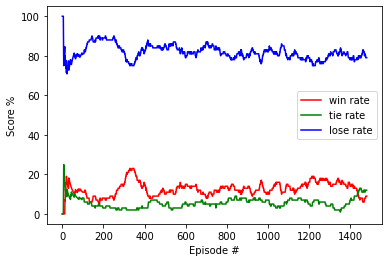

In [98]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc='best')
plt.show()